Побудувати CNN на основі ResNet-50 для класифікації зображень на основі  датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі  Siamese networks побудувати систему для пошуку подібних зображень в  датасеті fashion-mnist. Візуалізувати отримані результати t-SNE. 


In [17]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# !black drive/MyDrive/Y/3/lab3.ipynb

In [20]:
import keras
from keras import layers, models, utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
# %load_ext nb_black

In [16]:
train_data = pd.read_csv("/content/drive/MyDrive/data/fashion-mnist_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/data/fashion-mnist_test.csv")

In [22]:
x_train = train_data.iloc[:, 1:].values
y_train = train_data.label.values

x_test = test_data.iloc[:, 1:].values
y_test = test_data.label.values

x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((60000, 28, 28, 1), (60000,)), ((10000, 28, 28, 1), (10000,)))

In [23]:
def residual_block(input_data, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or input_data.shape[-1] != 4*filters:
        input_data = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
        input_data = layers.BatchNormalization()(input_data)
        
    x = layers.add([input_data, x])
    x = layers.Activation('relu')(x)
    
    return x


def resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name='input')
    x = layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    x = residual_block(x, filters=64, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet50')
    
    return model

In [24]:
model = resnet50(input_shape=(28,28,1),num_classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 64)   0           ['batch_normalization_5[0]

In [25]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [26]:
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True,
)

Epoch 1/30
235/235 [==============================] - 21s 22ms/step - loss: 0.6182 - accuracy: 0.7856 - val_loss: 4.1552 - val_accuracy: 0.1119
Epoch 2/30
235/235 [==============================] - 4s 18ms/step - loss: 0.3798 - accuracy: 0.8626 - val_loss: 0.6499 - val_accuracy: 0.7726
Epoch 3/30
235/235 [==============================] - 4s 16ms/step - loss: 0.3272 - accuracy: 0.8832 - val_loss: 0.7012 - val_accuracy: 0.7744
Epoch 4/30
235/235 [==============================] - 3s 14ms/step - loss: 0.3004 - accuracy: 0.8927 - val_loss: 0.3993 - val_accuracy: 0.8630
Epoch 5/30
235/235 [==============================] - 3s 12ms/step - loss: 0.2779 - accuracy: 0.9002 - val_loss: 0.5300 - val_accuracy: 0.8252
Epoch 6/30
235/235 [==============================] - 3s 12ms/step - loss: 0.2638 - accuracy: 0.9050 - val_loss: 0.3095 - val_accuracy: 0.8916
Epoch 7/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2487 - accuracy: 0.9106 - val_loss: 0.3747 - val_accuracy: 0.872

In [27]:
scores = model.evaluate(x_test, y_test)
scores

313/313 [==============================] - 1s 3ms/step - loss: 0.3871 - accuracy: 0.8767


[0.38706666231155396, 0.8766999840736389]

In [28]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]
print("train groups:", [x.shape[0] for x in train_groups])
print("test groups:", [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [29]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in group_idx
        ]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [
                np.random.choice([i for i in all_groups if i != c_idx])
                for c_idx in group_idx
            ]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in b_group_idx
        ]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [30]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name='FeatureExtractor')
new_model.summary()

Model: "FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 64)   0           ['batch_normalizat

In [31]:
img_a_in = layers.Input(shape=x_train.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=x_train.shape[1:], name="ImageB_Input")
img_a_feat = new_model(img_a_in)
img_b_feat = new_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 256)          80384       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 512)          0           ['FeatureExtractor[

In [32]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

1/1 [==============================] - 0s 74ms/step


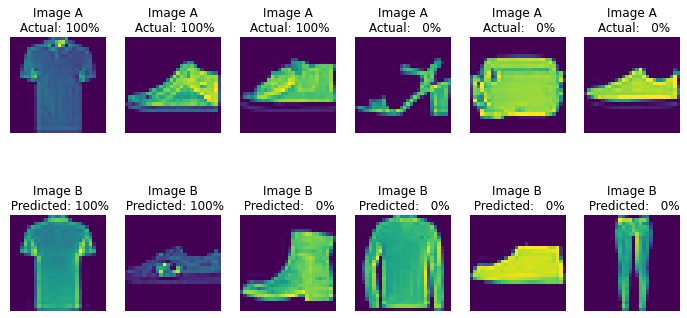

In [39]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


_ = show_model_output()

In [34]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True,
)

Epoch 1/10


<ipython-input-34-7a6f3930db49>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 43s 70ms/step - loss: 0.2596 - mae: 0.1678 - val_loss: 0.2519 - val_mae: 0.1399
Epoch 2/10
500/500 [==============================] - 24s 47ms/step - loss: 0.2053 - mae: 0.1267 - val_loss: 0.2147 - val_mae: 0.1291
Epoch 3/10
500/500 [==============================] - 22s 43ms/step - loss: 0.1833 - mae: 0.1116 - val_loss: 0.2335 - val_mae: 0.1454
Epoch 4/10
500/500 [==============================] - 25s 50ms/step - loss: 0.1766 - mae: 0.1073 - val_loss: 0.3417 - val_mae: 0.1441
Epoch 5/10
500/500 [==============================] - 24s 47ms/step - loss: 0.1658 - mae: 0.0999 - val_loss: 0.2085 - val_mae: 0.1152
Epoch 6/10
500/500 [==============================] - 22s 43ms/step - loss: 0.1677 - mae: 0.1019 - val_loss: 0.2167 - val_mae: 0.1160
Epoch 7/10
500/500 [==============================] - 24s 47ms/step - loss: 0.1582 - mae: 0.0954 - val_loss: 0.2564 - val_mae: 0.1343
Epoch 8/10
500/500 [==============================] - 23s 45ms/step - los

1/1 [==============================] - 0s 27ms/step


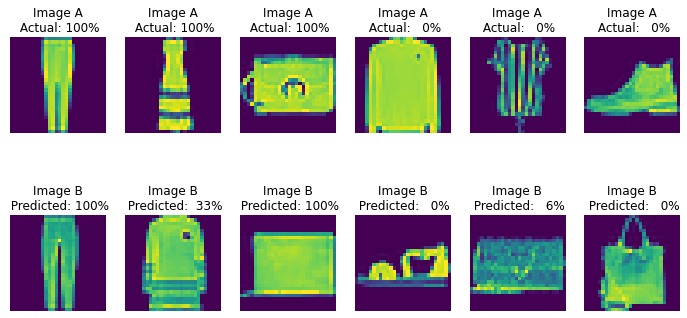

In [35]:
_ = show_model_output()

In [36]:


x_test_features = new_model.predict(x_test, verbose=True, batch_size=256)

40/40 [==============================] - 0s 3ms/step


In [37]:
%%time
from sklearn.manifold import TSNE

tsne_obj = TSNE(
    n_components=2,
    init="pca",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.945s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.800895
[t-SNE] Computed conditional probabilities in 0.384s
[t-SNE] Iteration 50: error = 84.0474548, gradient norm = 0.0275637 (50 iterations in 4.860s)
[t-SNE] It

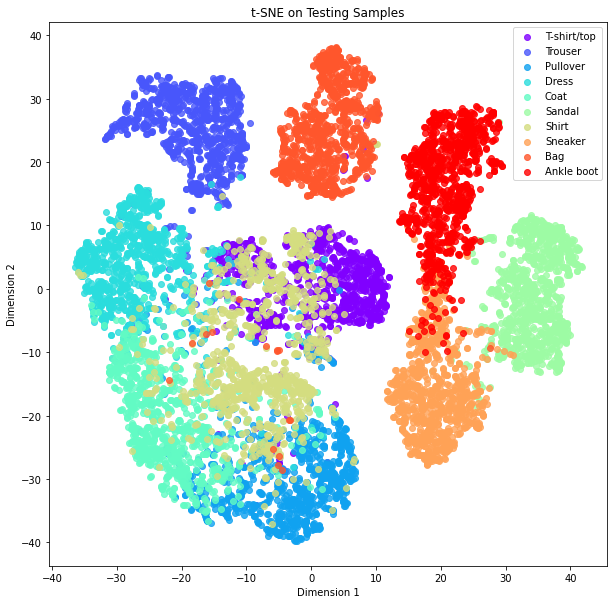

In [40]:
obj_categories = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
# plt.savefig('clothes-dist.png')
plt.show(block=False)